**DATA PREPROCESSING**

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [14]:
data.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [15]:
#filling missing bedrooms value with median

data['total_bedrooms'] = data['total_bedrooms'].fillna(data['total_bedrooms'].median())

In [16]:
#encoding Categorical Variables
data = pd.get_dummies(data, columns=['ocean_proximity'], drop_first=True)

In [17]:
#feature selection
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

In [18]:
#applying scalingscaler = StandardScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
#splitting into train test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

**MODEL IMPLEMENTATION**

In [20]:
#applying Linear Regression, Random Forest, and XGBoost models

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

model_lr = LinearRegression()
model_rf = RandomForestRegressor(random_state=42)
model_xgb = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

**PERFORMANCE COMPARISON**

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

y_pred_lr = model_lr.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Linear Regression - RMSE: {rmse_lr:.2f}, R²: {r2_lr:.2f}")
print(f"Random Forest - RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")
print(f"XGBoost - RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.2f}")


Linear Regression - RMSE: 70060.52, R²: 0.63
Random Forest - RMSE: 49034.57, R²: 0.82
XGBoost - RMSE: 47309.13, R²: 0.83


**Feature importance visualization for tree-based models.**

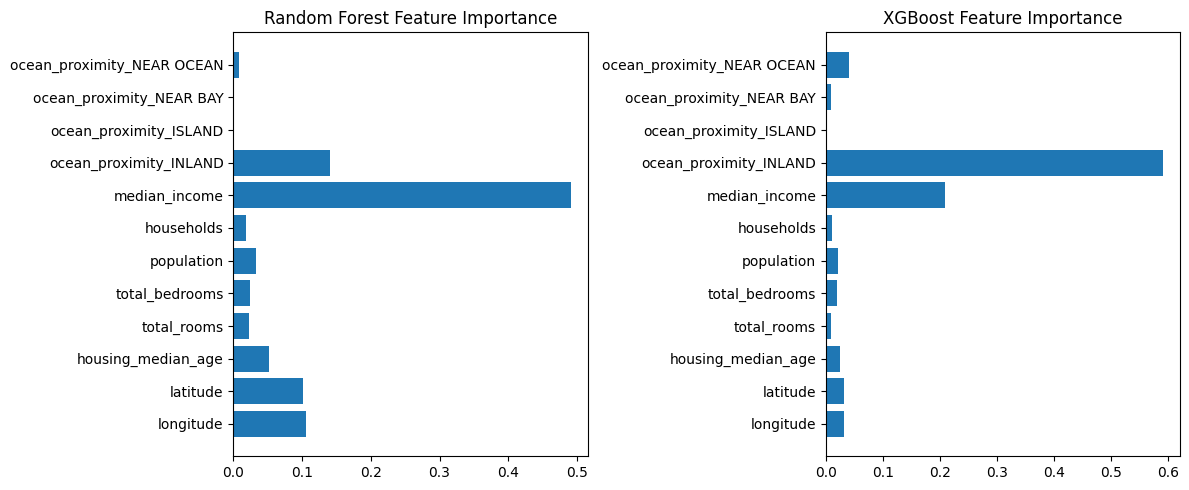

In [23]:
import matplotlib.pyplot as plt

importances_rf = model_rf.feature_importances_
importances_xgb = model_xgb.feature_importances_

features = X.columns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.barh(features, importances_rf)
plt.title("Random Forest Feature Importance")

plt.subplot(1, 2, 2)
plt.barh(features, importances_xgb)
plt.title("XGBoost Feature Importance")

plt.tight_layout()
plt.show()


**MODEL TESTING**

In [27]:
#testing with XGBoost as it has 83% accuracy

import pandas as pd
import numpy as np

feature_names = X.columns.tolist()

print("Please enter values for the following features:")

numeric_inputs = [
    'longitude', 'latitude', 'housing_median_age', 'total_rooms',
    'total_bedrooms', 'population', 'households', 'median_income'
]

input_values = {}

for feature in numeric_inputs:
    while True:
        try:
            val = float(input(f"{feature}: "))
            input_values[feature] = val
            break
        except ValueError:
            print("Invalid input, please enter a number.")

print("\nEnter True or False for each ocean proximity type:")

ocean_proximity_cols = [
    'ocean_proximity_INLAND',
    'ocean_proximity_ISLAND',
    'ocean_proximity_NEAR BAY',
    'ocean_proximity_NEAR OCEAN'
]

for col in ocean_proximity_cols:
    while True:
        val = input(f"{col} (True/False): ").strip().lower()
        if val in ['true', 'false']:
            input_values[col] = True if val == 'true' else False
            break
        else:
            print("Please enter either True or False.")

input_dict = {col: 0 for col in feature_names}
for key, val in input_values.items():
    input_dict[key] = val

input_df = pd.DataFrame([input_dict])

input_df_scaled = scaler.transform(input_df)
input_df_scaled = pd.DataFrame(input_df_scaled, columns=feature_names)

prediction = model_xgb.predict(input_df_scaled)[0]

print("\nPredicted Median House Value:")
print(f"${prediction:,.2f}")


Please enter values for the following features:
longitude: -122
latitude: 38
housing_median_age: 41
total_rooms: 880
total_bedrooms: 130
population: 320
households: 126
median_income: 8.3

Enter True or False for each ocean proximity type:
ocean_proximity_INLAND (True/False): False
ocean_proximity_ISLAND (True/False): False
ocean_proximity_NEAR BAY (True/False): True
ocean_proximity_NEAR OCEAN (True/False): False

Predicted Median House Value:
$321,358.84
